## Welcome to RL based Recommendation System

### This is part 1: Data Collection & Preprocessing (Amazon Reviews)
In this part we will:
1. Obtain a publicly available Amazon review dataset
2. Load, clean, transform, and split the data
3. Save the preprocessed data in a pickle file

In [49]:
#importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import pickle


### Step 0: Download the dataset
> http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz
<p>Save the dataset and copy its path in the `dataset_path` variable.</p>

### Step 1: Load the data into a Pandas DataFrame
<p>The file in JSON lines format (each line is a separate JSON object) and gzipped</p>

In [6]:
dataset_path = "/Ankit\Reposetories\RL_Based_Reccomendation_System\\reviews_Electronics_5.json.gz"
df = pd.read_json(dataset_path, lines=True, compression="gzip")
print(f"Loaded {len(df)} reviews")

Loaded 1689188 reviews


<p>Lets see what fields we have in our data</p>

In [7]:
df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


### Step 2: Feature selection
<p>We dont need all the columns in our data for a reccomendation sysyem.We will only select the following:</p>

1. reviewerID (or userID)
2. asis (or productID)
3. overall (rating)
4. unixReviewTime (timestamp of the review): This is useful for preserving sequence of actions.

<p> In this project we are focusing on rating based reccomendations, avoiding complexity of natural language processing of reviews </p>

In [9]:
df = df[['reviewerID', 'asin', 'overall', 'unixReviewTime']]
df.head(5)

,reviewerID,asin,overall,unixReviewTime
0,AO94DHGC771SJ,0528881469,5,1370131200
1,AMO214LNFCEI4,0528881469,1,1290643200
2,A3N7T0DY83Y4IG,0528881469,3,1283990400
3,A1H8PY3QHMQQA0,0528881469,2,1290556800
4,A24EV6RXELQZ63,0528881469,1,1317254400


### Step 3: Data cleaning
<p>We check the data for missing or NaN values, and remove any rows with missing values. This ensures data integrety and reliablity</p>

In [12]:
# We check for missing values
print("Missing values per column:\n", df.isnull().sum())

#Remove any columns with missing values
df = df.dropna()
print(f"\nAfter dropping missing values, {len(df)} reviews remain")

Missing values per column:
 reviewerID        0
asin              0
overall           0
unixReviewTime    0
dtype: int64

After dropping missing values, 1689188 reviews remain


<p>We see that no columns were dropped, which is a good thing. We have good data :)</p>

### Step 4: Map User and Item IDs to Integer Indices
<p>We can see that reviewerID and asin are string based. We will need to convert them to integer indices for better performance and avoid any complication with the data type during the training process.</p>
How would we do that?

1. Create dictionaries mapping unique reviewerID and asin values to integers using list comprehension and enumerate
2. Add new columns to the DataFrame using these mappings.

In [13]:
# Create mappings
user_to_idx = {user: idx for idx, user in enumerate(df['reviewerID'].unique())}
item_to_idx = {item: idx for idx, item in enumerate(df['asin'].unique())}

# Add integer indices to the dataframe
df['user_idx'] = df['reviewerID'].map(user_to_idx)
df['item_idx'] = df['asin'].map(item_to_idx)

print(f"Number of unique users: {len(user_to_idx)}")
print(f"Number of unique items: {len(item_to_idx)}")

Number of unique users: 192403
Number of unique items: 63001


In [14]:
df.head(5)

,reviewerID,asin,overall,unixReviewTime,user_idx,item_idx
0,AO94DHGC771SJ,0528881469,5,1370131200,0,0
1,AMO214LNFCEI4,0528881469,1,1290643200,1,0
2,A3N7T0DY83Y4IG,0528881469,3,1283990400,2,0
3,A1H8PY3QHMQQA0,0528881469,2,1290556800,3,0
4,A24EV6RXELQZ63,0528881469,1,1317254400,4,0


In [15]:
df.tail(5)

,reviewerID,asin,overall,unixReviewTime,user_idx,item_idx
1689183,A34BZM6S9L7QI4,B00LGQ6HL8,5,1405555200,114990,63000
1689184,A1G650TTTHEAL5,B00LGQ6HL8,5,1405382400,92852,63000
1689185,A25C2M3QF9G7OQ,B00LGQ6HL8,5,1405555200,10163,63000
1689186,A1E1LEVQ9VQNK,B00LGQ6HL8,5,1405641600,36698,63000
1689187,A2NYK9KWFMJV4Y,B00LGQ6HL8,5,1405209600,1615,63000


### Step 5: Sort Data by User and Timestamp
- Reinforcement Learning requires an understanding of the sequence of user interactions over time. Sorting ensures that each user’s reviews are in chronological order.
- It will also be easier when we need to group the data by user (for splitting)
<p>We will be sorting the dataframe on ``user_idx`` and ``unixReviewTime``</p>

In [17]:
df.sort_values(by=['user_idx', 'unixReviewTime'], inplace=True)
print("Data sorted by user_idx and unixReviewTime")

Data sorted by user_idx and unixReviewTime


In [18]:
df.head(5)

,reviewerID,asin,overall,unixReviewTime,user_idx,item_idx
1450204,AO94DHGC771SJ,B0096TK6MI,4,1353456000,0,53113
377374,AO94DHGC771SJ,B0013G8PTS,5,1366156800,0,15267
856723,AO94DHGC771SJ,B003ZBZ64Q,5,1366156800,0,32410
0,AO94DHGC771SJ,0528881469,5,1370131200,0,0
535992,AO94DHGC771SJ,B001TQSFXS,5,1375920000,0,21098


In [19]:
df.tail(5)

,reviewerID,asin,overall,unixReviewTime,user_idx,item_idx
1671048,A1FQ3HRVXA4A5B,B00GMRCAC6,5,1400630400,192402,61842
1665019,A1FQ3HRVXA4A5B,B00FZ5J8IA,5,1400716800,192402,61512
1683485,A1FQ3HRVXA4A5B,B00IFEERU2,5,1403395200,192402,62603
1688645,A1FQ3HRVXA4A5B,B00KC7I2GU,5,1403740800,192402,62958
1689051,A1FQ3HRVXA4A5B,B00KSLCU72,5,1403740800,192402,62991


### Step 6: Data visualisation
- Compute the number of users, items, and interactions
- Calculate sparsity of the user-item matrix
- Plot histograms of ratings and interactions
<p>This is a necessary step to get insight about our data validate that our preprocessing steps preserved the dataset’s integrity</p>

In [20]:
num_users = df['user_idx'].nunique()
num_items = df['item_idx'].nunique()
num_interactions = len(df)
sparsity = 1 - num_interactions / (num_users * num_items)

print(f"Users: {num_users}, Items: {num_items}, Interactions: {num_interactions}")
print(f"Sparsity: {sparsity:.6f}")

Users: 192403, Items: 63001, Interactions: 1689188
Sparsity: 0.999861


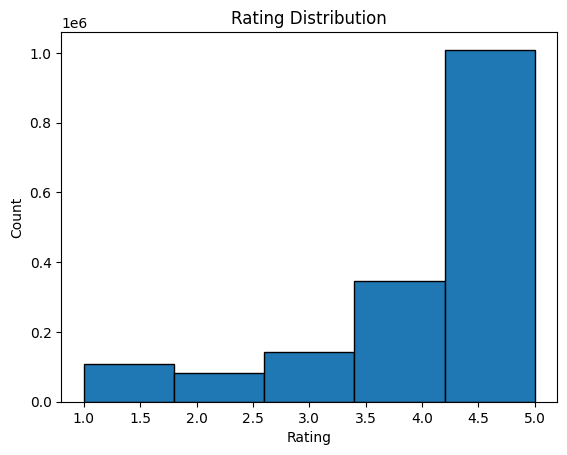

In [21]:
# Rating distribution
plt.hist(df['overall'], bins=5, edgecolor='black')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

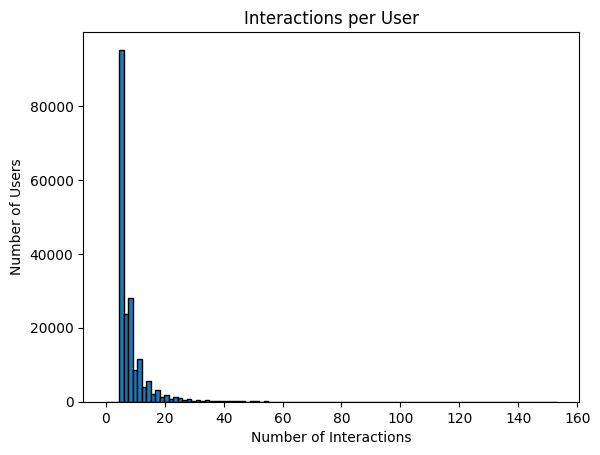

In [47]:
# Interactions per user
user_interactions = df.groupby('user_idx').size()
res = max(user_interactions, key=lambda k: user_interactions[k])
max_users = user_interactions[res]
plt.hist(user_interactions, range=(0, max_users+10) ,bins=100, edgecolor='black')

plt.title('Interactions per User')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.show()

We can note that:
1. Our data is not sparse
2. Our data is naturally distributed, and outliers are not very evident.
3. Most of the reviewers have posted between 1 and 20 reviews.

### Step 7: Split Data into Training and Testing Sets
<p>We will divide the data into training and testing sets by reserving the last interaction per user for testing.<br>Using the last interaction for testing mimics real-world scenarios where the model predicts future actions based on past data,</p> 


In [48]:
# Add rank to identify the last interaction per user
df['set'] = df.groupby('user_idx')['unixReviewTime'].rank(method='first', ascending=False).apply(lambda x: 'test' if x == 1 else 'train')

# Split into train and test DataFrames (optional)
df_train = df[df['set'] == 'train']
df_test = df[df['set'] == 'test']

print(f"Training set size: {len(df_train)} interactions")
print(f"Testing set size: {len(df_test)} interactions")

Training set size: 1496785 interactions
Testing set size: 192403 interactions


### Step 8: Save Preprocessed Data and Mappings
<p>We save the preprocessed DataFrame and ID mappings for use later.</p>

In [50]:
# Save the full preprocessed DataFrame
df.to_pickle('df_full.pkl')

# Save user and item mappings
with open('user_to_idx.pkl', 'wb') as f:
    pickle.dump(user_to_idx, f)
with open('item_to_idx.pkl', 'wb') as f:
    pickle.dump(item_to_idx, f)

print("Preprocessed data and mappings saved")

Preprocessed data and mappings saved


#### DONE
With this, we are done with the 1st part of the project! Next part is to set up the RL Environment.